In [3]:
%reload_ext autoreload
%autoreload 2
import opt
from spice_net import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Prelim

### Helpers

In [480]:
def train(net: LinearNetwork, xs, ys, epochs, gamma = 0.01, eta = 0.1, shuffle=True):
    n_nodes = len(net.__nodes__)
    n_edges = len(net.edges)

    loss = np.empty(epochs+1)
    weights = np.empty((epochs+1, xs.shape[0], n_edges))
    updates = np.empty((epochs, xs.shape[0], n_edges))

    # Calculate initial accuracy 
    pred = np.array([net.predict(x) for x in xs])
    loss[0] = np.sum((ys - pred)**2)
    weights[0] = np.tile([R.resistance for R in net.edges], (xs.shape[0],1))

    for i in range(epochs):
        if shuffle:
            perm = np.random.permutation(len(xs))
            xs = xs[perm]
            ys = ys[perm]
        for j, x, y in zip(range(xs.shape[0]), xs, ys):
            free = net.solve(x)
            nudges = eta * y + (1-eta) * net.predict(x)
            clamped = net.solve(x, nudges)

            free_rep = np.tile(free, [n_nodes, 1])
            clamped_rep = np.tile(clamped, [n_nodes,1])

            delta_free = free_rep - free_rep.T
            delta_clamped = clamped_rep - clamped_rep.T

            update = -gamma * (delta_clamped**2 - delta_free**2)
            trainable_updates = np.empty(n_edges)
            for k, R in enumerate(net.edges):
                a, b = list(map(int, R.node_names))
                trainable_updates[k] = update[a, b] #/ (R.resistance**2)

            net.update_y(trainable_updates)
            updates[i, j] = trainable_updates
            weights[i+1, j] = [R.resistance for R in net.edges]

        pred = np.array([net.predict(x) for x in xs])
        loss[i+1] = np.mean((ys - pred)**2)
        print(f'Epoch {i+1}: {loss[i+1]}')

    return net, loss, updates, weights
    
def visualize(net: LinearNetwork):
    G = nx.DiGraph()
    colors = []
    sources = []
    edges = []
    G.add_nodes_from(net.__nodes__)

    for R in net.edges:
        a, b = list(map(int, R.node_names))
        G.add_edge(a, b, weight=R.resistance, type='edge')
        G.add_edge(b, a, weight=R.resistance, type='edge')

    for V in net.inputs:
        a, b = list(map(int, V.node_names))
        G.add_edge(b, a, weight=V.dc_value, type='source', io='input')

    for V in net.outputs:
        a, b = list(map(int, V.node_names))
        G.add_edge(b, a, weight=V.dc_value, type='source', io='output')
        
    def filter_type(label):
        return lambda u, v: G.get_edge_data(u, v, default={'type':None})['type'] == label

    inputs_only = nx.subgraph_view(G, filter_edge=lambda u, v: filter_type('source')(u, v) and G.get_edge_data(u, v, default={'type':None})['io'] == 'input')
    outputs_only = nx.subgraph_view(G, filter_edge=lambda u, v: filter_type('source')(u, v) and G.get_edge_data(u, v, default={'type':None})['io'] == 'output')
    edges_only = nx.subgraph_view(G, filter_edge=filter_type('edge')).to_undirected(as_view=True)

    pos = nx.circular_layout(G)

    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(edges_only, pos, edge_color='black',)
    nx.draw_networkx_edge_labels(edges_only, pos, edge_labels={(u, v): round(edges_only[u][v]['weight'], 2) for u, v in edges_only.edges()})
    nx.draw_networkx_edges(inputs_only, pos, edge_color='red', connectionstyle='arc3,rad=0.2')
    nx.draw_networkx_edges(outputs_only, pos, edge_color='purple', connectionstyle='arc3,rad=0.2')
    # nx.draw_networkx_edge_labels(sources_only, pos, edge_labels={(u, v): sources_only[u][v]['io'] for u, v in sources_only.edges()},)


### Training a Toy Voltage Divider

In [360]:
vd = LinearNetwork('voltage_divider', con_mat=np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=float), node_cfg=(np.array([[2, 0]]), np.array([[1, 0]])), epsilon=1e-16)
# visualize(vd)

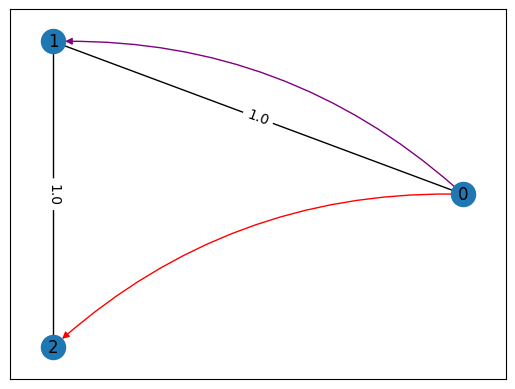

In [361]:
visualize(vd)

In [362]:
print(vd)

.title voltage_divider
R1 0 1 1.0
R2 1 2 1.0



In [363]:
dset = {}
dset['x'] = np.array([0, 1, 2, 3, 2, 1])[:,None]
dset['y'] = dset['x'] / 3

In [364]:
vd, loss, updates, weights = train(vd, dset['x'], dset['y'], 5, gamma=1)

Epoch 1: 0.008252615324855236
Epoch 2: 0.0006065849753331612
Epoch 3: 3.955051914838225e-05
Epoch 4: 2.4818265576646106e-06
Epoch 5: 1.5416799517657748e-07


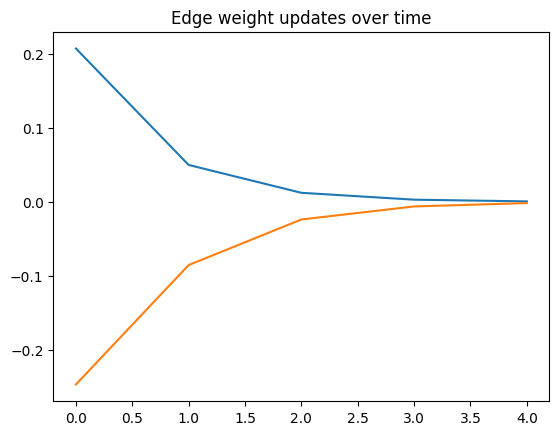

In [365]:
plt.plot(updates.sum(axis=1))
plt.title('Edge weight updates over time')
plt.show()

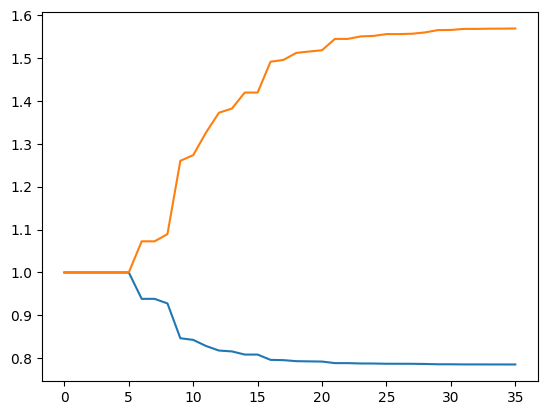

In [373]:
plt.plot(weights.reshape(-1, weights.shape[-1]))
plt.show()

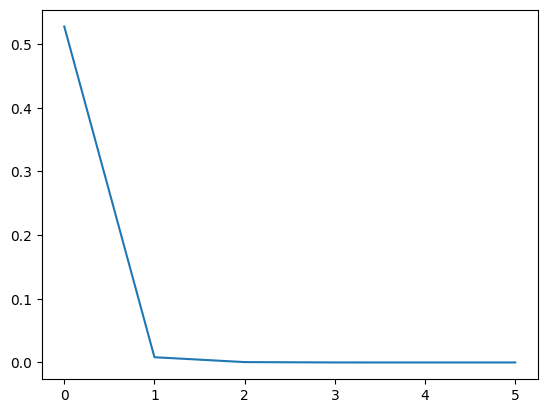

In [374]:
plt.plot(loss)
plt.show()

In [375]:
vd.predict(dset['x'][1])

array([0.33355397])

In [376]:
print(vd)

.title voltage_divider
V1 2 0 1
R1 0 1 0.7853900034304375
R2 1 2 1.5692214250827823



### Looking at inputs, outputs, and updates on toy dataset

In [30]:
eta = 0.1
for i in range(len(dset['x'])):
    free = vd.solve(dset['x'][i])
    nudges = eta * (dset['y'][i]) + (1-eta)*vd.predict(dset['x'][i])
    clamped = vd.solve(dset['x'][i], nudges)
    n = clamped.shape[0]
    free_rep = np.tile(free, [n, 1])
    clamped_rep = np.tile(clamped, [n,1])

    delta_free = free_rep - free_rep.T
    delta_clamped = clamped_rep - clamped_rep.T

    update = -10 * (delta_clamped**2 - delta_free**2) 

    trainable_updates = np.empty(len(vd.edges))
    for k, R in enumerate(vd.edges):
        a, b = list(map(int, R.node_names))
        trainable_updates[k] = update[a, b] 

    print(free, clamped, trainable_updates)

[0 0 0] [0 0 0] [0. 0.]
[0.         0.33355483 1.        ] [0.         0.33353269 1.        ] [ 0.00014771 -0.00029515]
[0.         0.66710967 2.        ] [0.         0.66706538 2.        ] [ 0.00059086 -0.00118059]
[0.         1.00066447 3.        ] [0.         1.00059807 3.        ] [ 0.00132883 -0.00265514]
[0.         0.66710967 2.        ] [0.         0.66706538 2.        ] [ 0.00059086 -0.00118059]
[0.         0.33355483 1.        ] [0.         0.33353269 1.        ] [ 0.00014771 -0.00029515]


In [31]:
print(vd)
vd.update_y(trainable_updates)
print(vd)

.title voltage_divider
V1 2 0 1
V2 1 0 0.3335326840480169
R1 0 1 0.7853912731278456
R2 1 2 1.5692178341440637

.title voltage_divider
V1 2 0 1
V2 1 0 0.3335326840480169
R1 0 1 0.7853001678571304
R2 1 2 1.5699449577033329



In [32]:
clamped, free

(array([0.        , 0.33353269, 1.        ]),
 array([0.        , 0.33355483, 1.        ]))

In [33]:
update

array([[-0.        ,  0.00014771, -0.        ],
       [ 0.00014771, -0.        , -0.00029515],
       [-0.        , -0.00029515, -0.        ]])

In [35]:
delta_clamped**2, delta_free**2

(array([[0.        , 0.11124406, 1.        ],
        [0.11124406, 0.        , 0.44417867],
        [1.        , 0.44417867, 0.        ]]),
 array([[0.        , 0.11125883, 1.        ],
        [0.11125883, 0.        , 0.44414916],
        [1.        , 0.44414916, 0.        ]]))

In [175]:
[(i, vd.predict(i)) for i in dset['x']]

[(0, array([0])),
 (1, array([1.])),
 (2, array([2.])),
 (3, array([3.])),
 (2, array([2.])),
 (1, array([1.]))]

In [181]:
print(vd)

.title voltage_divider
R0 0 1 1e-16
R1 1 2 1.0



## Linear Regression

#### Generate the dataset

In [103]:
# Generate N random points
N = 32
split = 0.8
pts = np.random.rand(N) 
sigma = 0.001

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split), None], pts[int(N*split):, None]

# Generate categories with nonlinear decision boundary
m = np.random.random()
b = np.random.random()

model = (lambda m, b: lambda x: -m*x - b)(m, b)

training['y'] = model(training['x']) + np.random.normal(0, sigma, training['x'].shape)
test['y'] = model(test['x']) + np.random.normal(0, sigma, test['x'].shape)

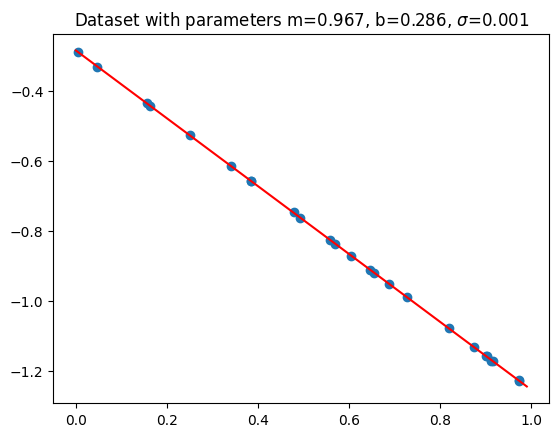

In [104]:
# Visualize dataset
plt.scatter(training['x'], training['y'])
xs = np.arange(0, 1, 0.01)
plt.plot(xs, model(xs), 'r',)
plt.title(fr'Dataset with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

#### Generate random linear network

In [465]:
# Parameters
nodes = 6
edge_prob = 1.0
con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob)
for u, v in con_graph.edges():
    # con_graph[u][v]['weight'] = 1. 
    con_graph[u][v]['weight'] = 1./np.random.rand()

print('Num edges:', con_graph.number_of_edges())
con_mat = nx.to_numpy_array(con_graph)

in_nodes = 2
out_nodes = 1
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 15


(array([[4, 5],
        [3, 0]]),
 array([[1, 2]]))

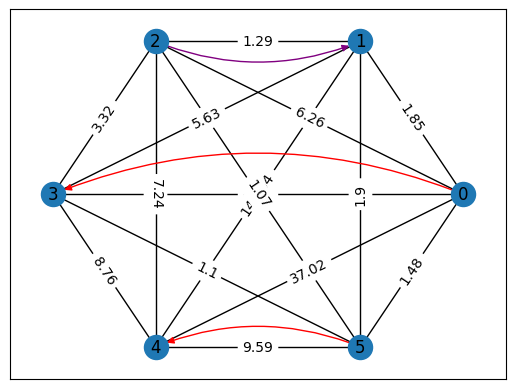

In [466]:
lin = LinearNetwork('fully_connected', con_mat, node_cfg)
visualize(lin)

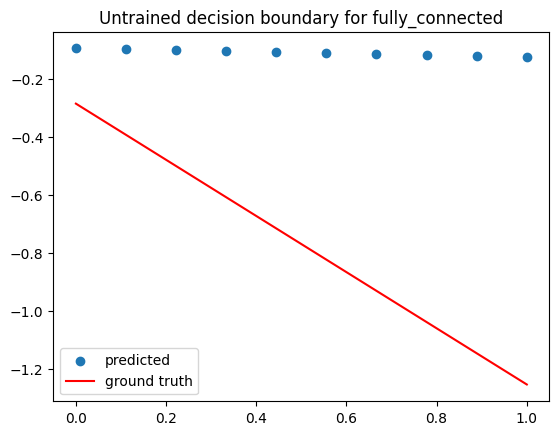

In [467]:
test_net = lin
lh = 1
num_pts = 10
xs = np.linspace(0, lh, num_pts)
ys = [test_net.predict([x, 1]) for x in np.linspace(0, lh, num_pts)]
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train both networks

In [468]:
augmented = np.hstack((training['x'], np.ones(training['x'].shape)))

In [472]:
# Train linear network
epochs = 10
trained_lin, loss, updates, weights = train(lin, augmented, training['y'], epochs, gamma=10, eta=0.1)

Epoch 1: 0.019196077461389592
Epoch 2: 0.01230479669500191
Epoch 3: 0.02460694467769018
Epoch 4: 0.01855103490134696
Epoch 5: 0.011033389170751301
Epoch 6: 0.005311827893380135
Epoch 7: 0.004391927458805307
Epoch 8: 0.0029630462465284712
Epoch 9: 0.0017779469648013392
Epoch 10: 0.0011392369314783073


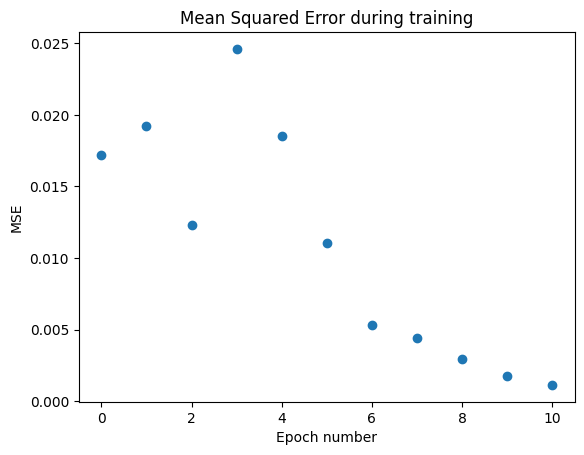

In [473]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

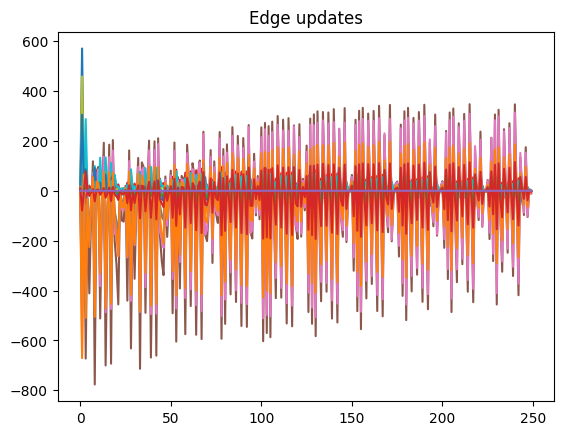

In [477]:
plt.plot(updates.reshape(-1, updates.shape[-1]))
# plt.plot(np.clip(updates.reshape(-1, updates.shape[-1])[:,1./weights[-1,-1,:] > 1e-5], -5, 5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

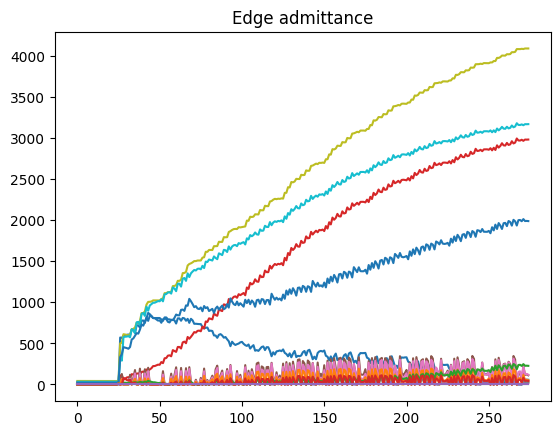

In [475]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

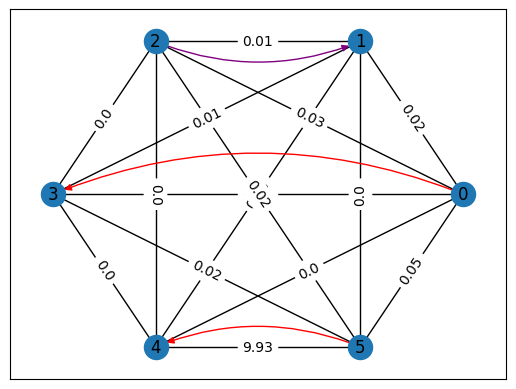

In [478]:
visualize(trained_lin)

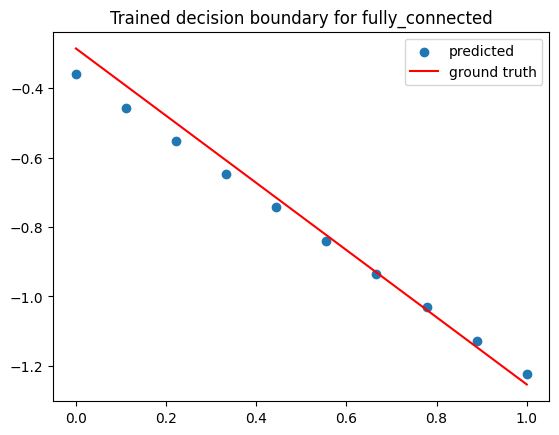

In [479]:
test_net = lin
lh = 1
num_pts = 10
xs = np.linspace(0, lh, num_pts)
ys = [test_net.predict([x,1]) for x in np.linspace(0, lh, num_pts)]
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()

### Visualize training results over time

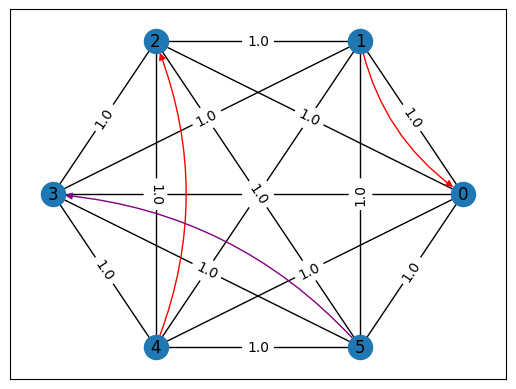

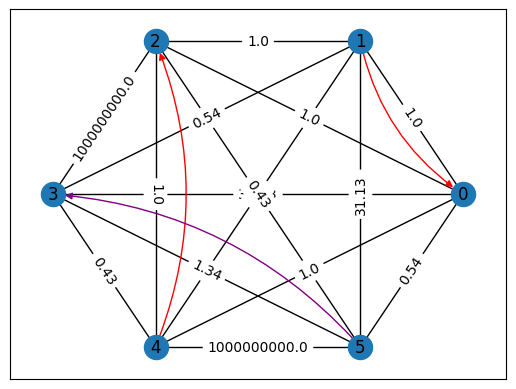

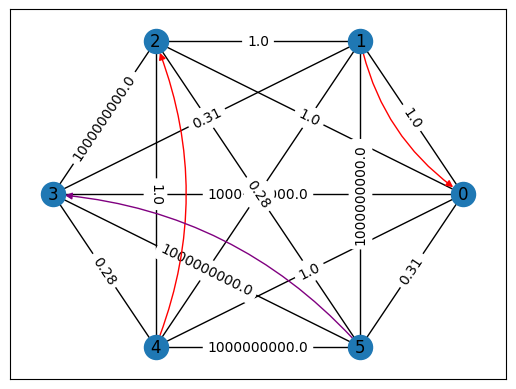

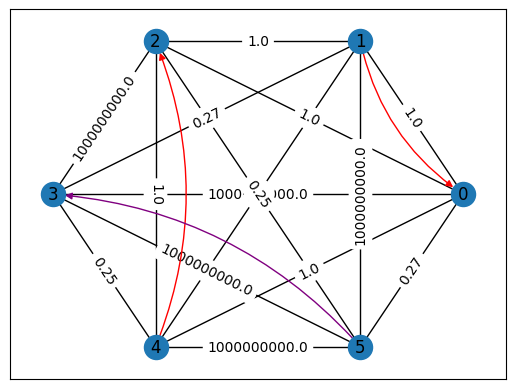

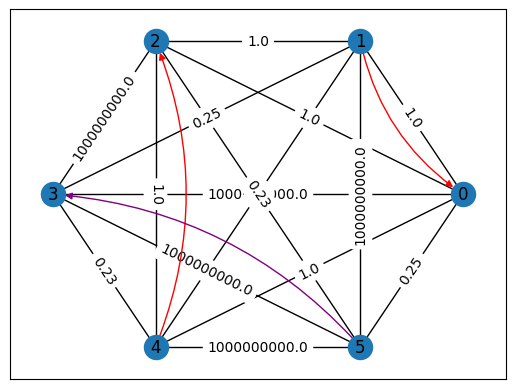

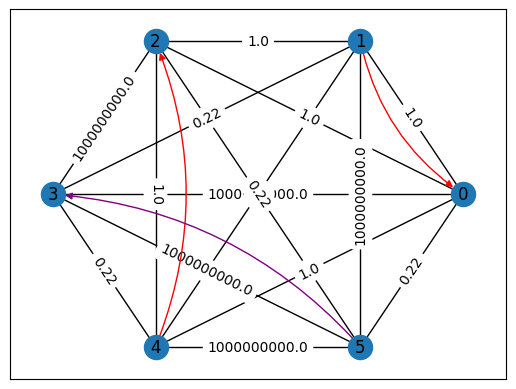

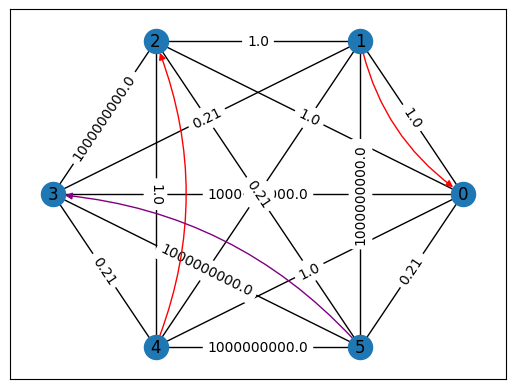

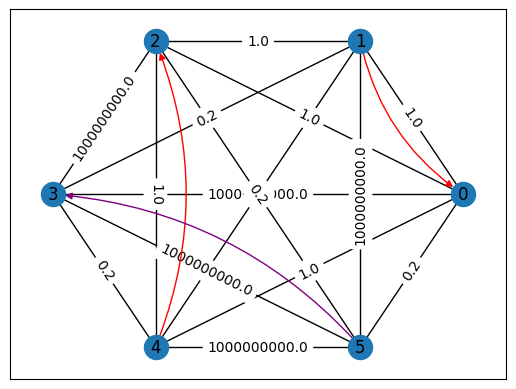

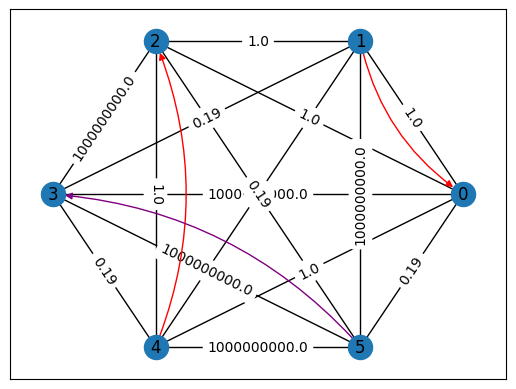

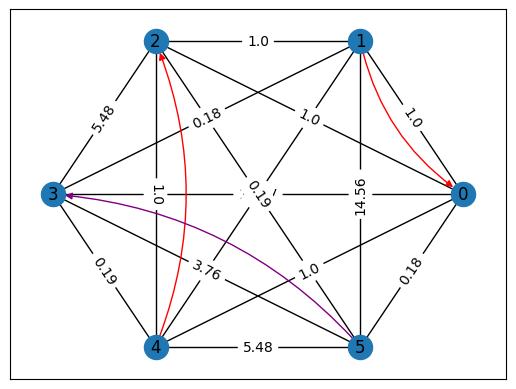

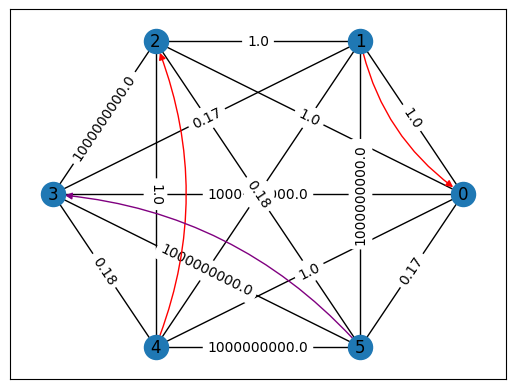

In [274]:
for test_it in range(epochs+1):
    tm = np.zeros((len(lin.__nodes__), len(lin.__nodes__)))
    for i, R in enumerate(lin.edges):
        a, b = list(map(int, R.node_names))
        tm[a, b] = weights[test_it,0][i]
        tm[b, a] = weights[test_it,0][i]
    test_net = LinearNetwork(f'{lin.name}_{test_it}', con_mat = tm, node_cfg=node_cfg)
    lh = 1
    num_pts = 10
    xs = np.linspace(0, lh, num_pts)
    ys = [test_net.predict([x,1]) for x in np.linspace(0, lh, num_pts)]

    # plt.scatter(xs, ys)
    # plt.plot(xs, model(xs), 'r')
    # plt.title(f'Decision boundary for {test_net.name}')
    # plt.legend(['predicted', 'ground truth'])
    # plt.show()
    visualize(test_net)
    plt.show()
    loss[test_it]